# GudangPintar: Inventory Control Analysis
**Dataset:** 20 SKU × 15 bulan (Januari 2025 – Maret 2026) | 312 baris  
**Tools:** JupySQL + DuckDB + Matplotlib  
**Tujuan:** Menjawab 3 pertanyaan analisis untuk Operations Manager Pak Yusuf

---
> **Skenario:** GudangPintar mengalami kerugian **Rp 500 juta/bulan** akibat stockout berulang sekaligus overstock di kategori lain. Kita bertugas membuat laporan analisis inventory untuk menemukan root cause dan rekomendasi.

## Pertanyaan Analisis
1. SKU & kategori mana yang paling sering **stockout**?
2. Supplier mana yang **tidak reliable** (lead time tinggi & tidak konsisten)?
3. Kategori mana yang **overstock** dan berapa modal yang tertahan?

In [1]:
# ── Setup & Imports ──────────────────────────────────────────────────────────
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch

# Gaya visualisasi
plt.rcParams.update({
    'figure.figsize': (10, 5),
    'axes.titlesize': 13,
    'axes.titleweight': 'bold',
    'axes.spines.top': False,
    'axes.spines.right': False,
})
sns.set_palette('Set2')

print("Library berhasil dimuat")

Library berhasil dimuat


In [2]:
# ── JupySQL + DuckDB Setup ────────────────────────────────────────────────────
%load_ext sql

# Hubungkan ke DuckDB in-memory
%sql duckdb:///:memory:

# Konfigurasi tampilan hasil query
%config SqlMagic.autopandas = False
%config SqlMagic.feedback = 0
%config SqlMagic.displaycon = False

print("JupySQL + DuckDB terhubung")

Connecting to 'duckdb:///:memory:'

JupySQL + DuckDB terhubung


---
## 1. Load Data

Kita load file CSV langsung ke DuckDB menggunakan `read_csv_auto()`.  
DuckDB bisa membaca CSV **tanpa perlu load ke memori pandas terlebih dahulu** — inilah keunggulan SQL-first workflow.  
Data langsung tersedia sebagai tabel SQL yang bisa di-query seperti database biasa.

In [3]:
%%sql
-- Buat tabel dari CSV langsung (DuckDB auto-detect types)
CREATE OR REPLACE TABLE inventory_raw AS
SELECT * FROM read_csv_auto('dataset/data.csv',
    nullstr = ['', 'nan', 'NULL', 'null'],
    dateformat = '%Y-%m-%d'
);

-- Konfirmasi jumlah baris
SELECT COUNT(*) AS total_baris FROM inventory_raw;

total_baris
312


In [4]:
%%sql
-- Cek struktur tabel: nama kolom & tipe data yang terdeteksi DuckDB
DESCRIBE inventory_raw;

column_name,column_type,null,key,default,extra
SKU,VARCHAR,YES,None,None,None
ProductName,VARCHAR,YES,None,None,None
Category,VARCHAR,YES,None,None,None
CurrentStock,DOUBLE,YES,None,None,None
ReorderPoint,BIGINT,YES,None,None,None
DailySalesAvg,DOUBLE,YES,None,None,None
LeadTime,DOUBLE,YES,None,None,None
SupplierID,VARCHAR,YES,None,None,None
LastRestockDate,DATE,YES,None,None,None
UnitPrice,DOUBLE,YES,None,None,None


In [5]:
%%sql
-- Lihat 5 baris pertama untuk memahami bentuk data
SELECT * FROM inventory_raw LIMIT 5;

SKU,ProductName,Category,CurrentStock,ReorderPoint,DailySalesAvg,LeadTime,SupplierID,LastRestockDate,UnitPrice,SnapshotDate
SKU-016,Parfum EDT Brasov 100ml,Beauty,271.0,50,2.0,4.0,SUP_BT02,2025-04-01,125000.0,2025-04-01
SKU-001,Laptop ASUS Vivobook,Electronics,21.0,15,4.0,5.0,SUP_EL01,2025-10-12,8500000.0,2025-10-01
SKU-004,Smartwatch Xiaomi Band,Electronics,30.0,30,2.0,7.0,SUP_EL01,2026-01-07,1200000.0,2026-01-01
SKU-005,Kemeja Formal Pria,Fashion,25.0,50,6.0,3.0,SUP_FA01,2025-01-31,350000.0,2025-01-01
SKU-002,Smartphone Samsung A54,Electronics,0.0,25,7.0,21.0,SUP_EL02,2025-11-17,4500000.0,2025-11-01


In [6]:
%%sql
-- Validasi: konfirmasi rentang tanggal sudah benar
-- Harus: Jan 2025 s/d Mar 2026 (15 bulan)
SELECT
    MIN(SnapshotDate) AS tanggal_awal,
    MAX(SnapshotDate) AS tanggal_akhir,
    COUNT(DISTINCT SnapshotDate) AS jumlah_bulan
FROM inventory_raw;

tanggal_awal,tanggal_akhir,jumlah_bulan
2025-01-01,2026-03-01,15


---
## 2. Eksplorasi Data Awal

Sebelum analisis, kita perlu memahami:
- Berapa baris & kolom yang ada?
- Distribusi data per kategori dan per bulan?
- Ada nilai kosong (NULL) di kolom mana saja? — ini penting karena NULL bisa merusak perhitungan

In [7]:
%%sql
-- Hitung NULL per kolom
-- Trik: COUNT() mengabaikan NULL, jadi COUNT(*) - COUNT(kolom) = jumlah NULL
SELECT
    COUNT(*) - COUNT(CurrentStock)    AS null_CurrentStock,
    COUNT(*) - COUNT(DailySalesAvg)   AS null_DailySalesAvg,
    COUNT(*) - COUNT(LeadTime)        AS null_LeadTime,
    COUNT(*) - COUNT(UnitPrice)       AS null_UnitPrice,
    COUNT(*) - COUNT(LastRestockDate) AS null_LastRestockDate
FROM inventory_raw;

null_CurrentStock,null_DailySalesAvg,null_LeadTime,null_UnitPrice,null_LastRestockDate
3,1,4,2,0


In [8]:
%%sql
-- Distribusi baris per kategori
-- Pastikan setiap kategori memiliki 4 SKU × 15 bulan = 60 baris
SELECT
    Category,
    COUNT(*)              AS jumlah_baris,
    COUNT(DISTINCT SKU)   AS jumlah_sku,
    COUNT(DISTINCT SnapshotDate) AS jumlah_bulan
FROM inventory_raw
GROUP BY Category
ORDER BY jumlah_baris DESC;

Category,jumlah_baris,jumlah_sku,jumlah_bulan
Beauty,64,4,15
Fashion,63,4,15
Electronics,62,4,15
Home & Living,62,4,15
Food & Beverage,61,4,15


In [9]:
%%sql
-- Daftar bulan yang ada dalam dataset
-- Snapshot diambil tanggal 1 tiap bulan, Jan 2025 s/d Mar 2026 = 15 bulan
SELECT
    strftime(SnapshotDate, '%Y-%m') AS bulan,
    COUNT(*) AS jumlah_record
FROM inventory_raw
GROUP BY bulan
ORDER BY bulan;

bulan,jumlah_record
2025-01,21
2025-02,20
2025-03,20
2025-04,20
2025-05,20
2025-06,20
2025-07,20
2025-08,21
2025-09,21
2025-10,22


---
## 3. Data Cleaning

Kita temukan **10 nilai NULL** di 4 kolom. Strategi pembersihan:

| Kolom | Jumlah NULL | Strategi |
|-------|-------------|----------|
| `CurrentStock` | 3 | Impute dengan **median per SKU** |
| `DailySalesAvg` | 1 | Impute dengan **median per SKU** |
| `LeadTime` | 4 | Impute dengan **median per SKU** |
| `UnitPrice` | 2 | Impute dengan **median per SKU** |

**Mengapa median?**  
Median lebih robust terhadap outlier dibanding mean. Untuk produk yang sama (SKU sama), nilai historis dari bulan lain adalah estimasi terbaik untuk bulan yang datanya hilang.

**Teknik SQL:** `PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY kolom)` = median dalam SQL standar.

In [10]:
%%sql
-- Buat tabel bersih dengan NULL ter-impute menggunakan median per SKU
CREATE OR REPLACE TABLE inventory_clean AS
WITH median_per_sku AS (
    SELECT
        SKU,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY CurrentStock)  AS med_stock,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY DailySalesAvg) AS med_sales,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY LeadTime)      AS med_lead,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY UnitPrice)     AS med_price
    FROM inventory_raw
    GROUP BY SKU
)
SELECT
    r.SKU,
    r.ProductName,
    r.Category,
    COALESCE(r.CurrentStock,  m.med_stock)  AS CurrentStock,
    r.ReorderPoint,
    COALESCE(r.DailySalesAvg, m.med_sales)  AS DailySalesAvg,
    COALESCE(r.LeadTime,      m.med_lead)   AS LeadTime,
    r.SupplierID,
    r.LastRestockDate,
    COALESCE(r.UnitPrice,     m.med_price)  AS UnitPrice,
    r.SnapshotDate
FROM inventory_raw r
JOIN median_per_sku m USING (SKU);

-- Verifikasi: semua kolom harus 0 NULL setelah cleaning
SELECT
    COUNT(*) - COUNT(CurrentStock)  AS null_CurrentStock,
    COUNT(*) - COUNT(DailySalesAvg) AS null_DailySalesAvg,
    COUNT(*) - COUNT(LeadTime)      AS null_LeadTime,
    COUNT(*) - COUNT(UnitPrice)     AS null_UnitPrice
FROM inventory_clean;

null_CurrentStock,null_DailySalesAvg,null_LeadTime,null_UnitPrice
0,0,0,0


In [11]:
%%sql
-- Konfirmasi: jumlah baris tidak berkurang setelah cleaning
SELECT
    (SELECT COUNT(*) FROM inventory_raw)   AS baris_raw,
    (SELECT COUNT(*) FROM inventory_clean) AS baris_clean;

baris_raw,baris_clean
312,312


---
## 4. Analisis Stockout

**Definisi stockout:** `CurrentStock < ReorderPoint`  
Artinya stok sudah di bawah batas aman dan seharusnya sudah di-reorder.

**Stock Out Rate** = (jumlah bulan stockout ÷ total bulan dicatat) × 100%  
Semakin tinggi = semakin sering SKU ini kehabisan stok.

In [12]:
%%sql
-- Stock out rate per SKU — diurutkan dari yang paling sering stockout
SELECT
    SKU,
    ProductName,
    Category,
    COUNT(*)  AS total_bulan,
    SUM(CASE WHEN CurrentStock < ReorderPoint THEN 1 ELSE 0 END) AS bulan_stockout,
    ROUND(
        100.0 * SUM(CASE WHEN CurrentStock < ReorderPoint THEN 1 ELSE 0 END) / COUNT(*),
        1
    ) AS stock_out_rate_pct
FROM inventory_clean
GROUP BY SKU, ProductName, Category
ORDER BY stock_out_rate_pct DESC
LIMIT 10;

SKU,ProductName,Category,total_bulan,bulan_stockout,stock_out_rate_pct
SKU-018,Teh Organik Premium Box,Food & Beverage,15,15,100.0
SKU-005,Kemeja Formal Pria,Fashion,16,16,100.0
SKU-007,Sepatu Sneakers Nike,Fashion,15,15,100.0
SKU-006,Dress Casual Wanita,Fashion,16,16,100.0
SKU-019,Madu Hutan Asli 500ml,Food & Beverage,16,16,100.0
SKU-008,Tas Ransel Eiger,Fashion,16,14,87.5
SKU-017,Kopi Arabika 250g Pack,Food & Beverage,15,13,86.7
SKU-020,Snack Granola Mix 500g,Food & Beverage,15,12,80.0
SKU-002,Smartphone Samsung A54,Electronics,16,11,68.8
SKU-003,Headphone Sony WH-1000,Electronics,15,9,60.0


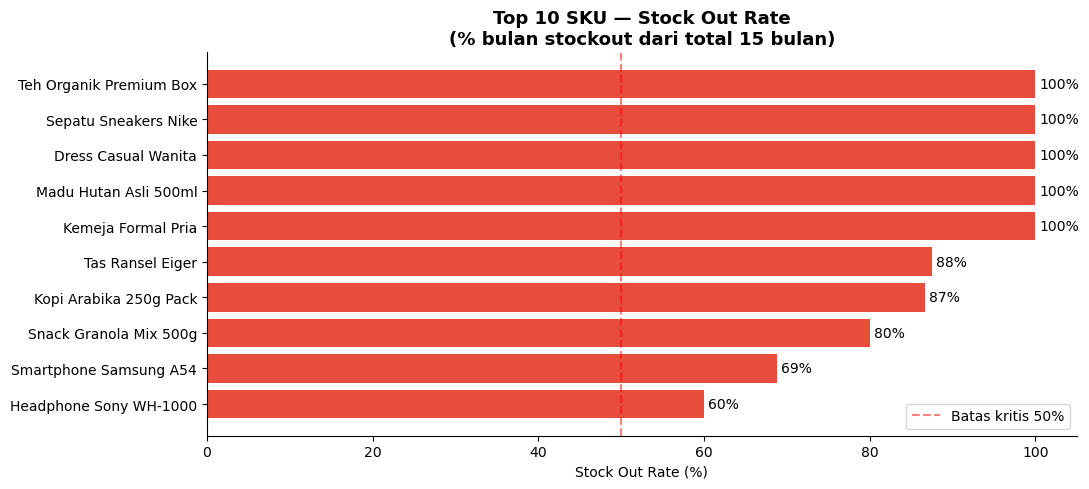

In [13]:
# Visualisasi: Stock out rate per SKU (bar chart horizontal)
stockout_sku = %sql SELECT SKU, ProductName, Category,     ROUND(100.0 * SUM(CASE WHEN CurrentStock < ReorderPoint THEN 1 ELSE 0 END) / COUNT(*), 1) AS rate     FROM inventory_clean GROUP BY SKU, ProductName, Category ORDER BY rate DESC LIMIT 10
df_stockout = stockout_sku.DataFrame()

fig, ax = plt.subplots(figsize=(11, 5))
# Warna: merah jika >= 50%, oranye jika >= 25%, hijau jika < 25%
colors = ['#e74c3c' if r >= 50 else '#e67e22' if r >= 25 else '#2ecc71'
          for r in df_stockout['rate']]
bars = ax.barh(df_stockout['ProductName'], df_stockout['rate'], color=colors)

# Label nilai di ujung bar
for bar, val in zip(bars, df_stockout['rate']):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{val:.0f}%', va='center', fontsize=10)

ax.set_xlabel('Stock Out Rate (%)')
ax.set_title('Top 10 SKU — Stock Out Rate\n(% bulan stockout dari total 15 bulan)')
ax.axvline(50, color='red', linestyle='--', alpha=0.5, label='Batas kritis 50%')
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [14]:
%%sql
-- Stock out rate per kategori — untuk melihat kategori mana yang paling bermasalah
SELECT
    Category,
    COUNT(*)  AS total_records,
    SUM(CASE WHEN CurrentStock < ReorderPoint THEN 1 ELSE 0 END) AS total_stockout,
    ROUND(
        100.0 * SUM(CASE WHEN CurrentStock < ReorderPoint THEN 1 ELSE 0 END) / COUNT(*),
        1
    ) AS stock_out_rate_pct,
    COUNT(DISTINCT SKU) AS jumlah_sku
FROM inventory_clean
GROUP BY Category
ORDER BY stock_out_rate_pct DESC;

Category,total_records,total_stockout,stock_out_rate_pct,jumlah_sku
Fashion,63,61,96.8,4
Food & Beverage,61,56,91.8,4
Electronics,62,34,54.8,4
Home & Living,62,15,24.2,4
Beauty,64,1,1.6,4


In [15]:
%%sql
-- Tren stockout per bulan — apakah memburuk atau membaik dari waktu ke waktu?
SELECT
    strftime(SnapshotDate, '%Y-%m') AS bulan,
    COUNT(*) AS total_sku_dicatat,
    SUM(CASE WHEN CurrentStock < ReorderPoint THEN 1 ELSE 0 END) AS sku_stockout,
    ROUND(
        100.0 * SUM(CASE WHEN CurrentStock < ReorderPoint THEN 1 ELSE 0 END) / COUNT(*),
        1
    ) AS pct_stockout
FROM inventory_clean
GROUP BY bulan
ORDER BY bulan;

bulan,total_sku_dicatat,sku_stockout,pct_stockout
2025-01,21,10,47.6
2025-02,20,11,55.0
2025-03,20,14,70.0
2025-04,20,9,45.0
2025-05,20,11,55.0
2025-06,20,12,60.0
2025-07,20,14,70.0
2025-08,21,8,38.1
2025-09,21,8,38.1
2025-10,22,12,54.5


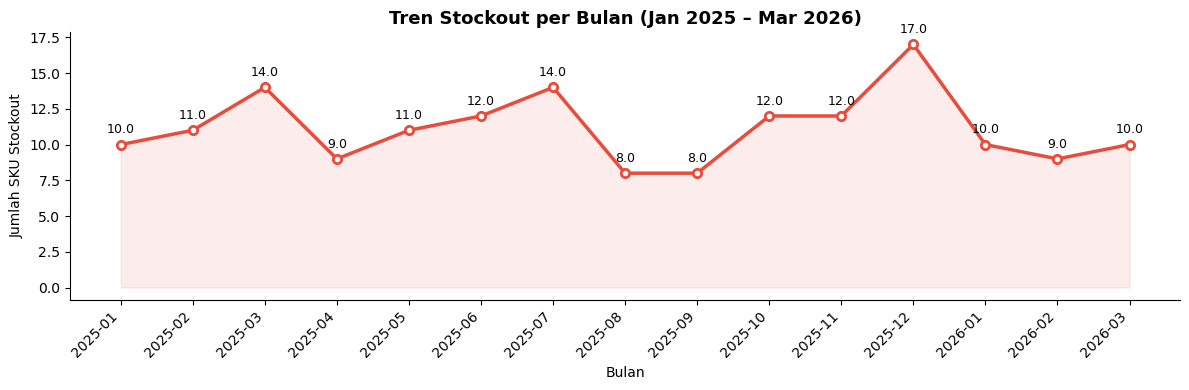

In [16]:
# Visualisasi: Tren stockout per bulan (line chart)
trend = %sql SELECT strftime(SnapshotDate, '%Y-%m') AS bulan,     SUM(CASE WHEN CurrentStock < ReorderPoint THEN 1 ELSE 0 END) AS sku_stockout     FROM inventory_clean GROUP BY bulan ORDER BY bulan
df_trend = trend.DataFrame()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_trend['bulan'], df_trend['sku_stockout'], marker='o', linewidth=2.5,
        color='#e74c3c', markerfacecolor='white', markeredgewidth=2)
ax.fill_between(range(len(df_trend)), df_trend['sku_stockout'], alpha=0.1, color='#e74c3c')
ax.set_xticks(range(len(df_trend)))
ax.set_xticklabels(df_trend['bulan'], rotation=45, ha='right')
ax.set_xlabel('Bulan')
ax.set_ylabel('Jumlah SKU Stockout')
ax.set_title('Tren Stockout per Bulan (Jan 2025 – Mar 2026)')
for i, v in enumerate(df_trend['sku_stockout']):
    ax.annotate(str(v), (i, v), textcoords='offset points', xytext=(0, 8),
                ha='center', fontsize=9)
plt.tight_layout()
plt.show()

---
## 5. Analisis Supplier Reliability

Supplier yang tidak reliable = lead time panjang **dan/atau** tidak konsisten.

Metrik yang digunakan:
- **Avg Lead Time** — rata-rata waktu tunggu (hari); semakin lama = semakin banyak stok safety yang dibutuhkan
- **Std Dev Lead Time** — seberapa bervariasi lead time-nya; semakin tinggi = semakin tidak bisa diprediksi
- **Max Lead Time** — worst-case scenario — berapa lama paling lambat pengiriman datang

**Aturan praktis:** Supplier dengan std dev > 3 hari dianggap tidak konsisten (sulit diplan).

In [17]:
%%sql
-- Statistik lead time per supplier — lengkap dengan status reliability
SELECT
    SupplierID,
    COUNT(DISTINCT SKU)    AS jumlah_sku,
    COUNT(*)               AS total_records,
    ROUND(AVG(LeadTime), 1)    AS avg_lead_time,
    ROUND(STDDEV(LeadTime), 1) AS stddev_lead_time,
    MIN(LeadTime)              AS min_lead_time,
    MAX(LeadTime)              AS max_lead_time,
    CASE
        WHEN STDDEV(LeadTime) > 3 AND AVG(LeadTime) > 7 THEN 'Tidak Reliable'
        WHEN STDDEV(LeadTime) > 3 OR  AVG(LeadTime) > 7 THEN 'Perlu Perhatian'
        ELSE 'OK'
    END AS status
FROM inventory_clean
GROUP BY SupplierID
ORDER BY stddev_lead_time DESC;

SupplierID,jumlah_sku,total_records,avg_lead_time,stddev_lead_time,min_lead_time,max_lead_time,status
SUP_EL02,2,31,14.0,4.7,7.0,23.0,Tidak Reliable
SUP_HM02,2,32,7.1,2.2,4.0,10.0,Perlu Perhatian
SUP_FA02,2,31,5.7,1.8,3.0,9.0,OK
SUP_BT02,2,32,6.3,1.5,4.0,8.0,OK
SUP_FA01,2,32,4.7,1.5,3.0,7.0,OK
SUP_EL01,2,31,6.5,1.4,5.0,9.0,OK
SUP_FB02,2,31,5.3,1.2,3.0,7.0,OK
SUP_HM01,2,30,8.6,1.2,6.0,10.0,Perlu Perhatian
SUP_BT01,2,32,4.9,0.8,4.0,6.0,OK
SUP_FB01,2,30,4.1,0.7,3.0,5.0,OK


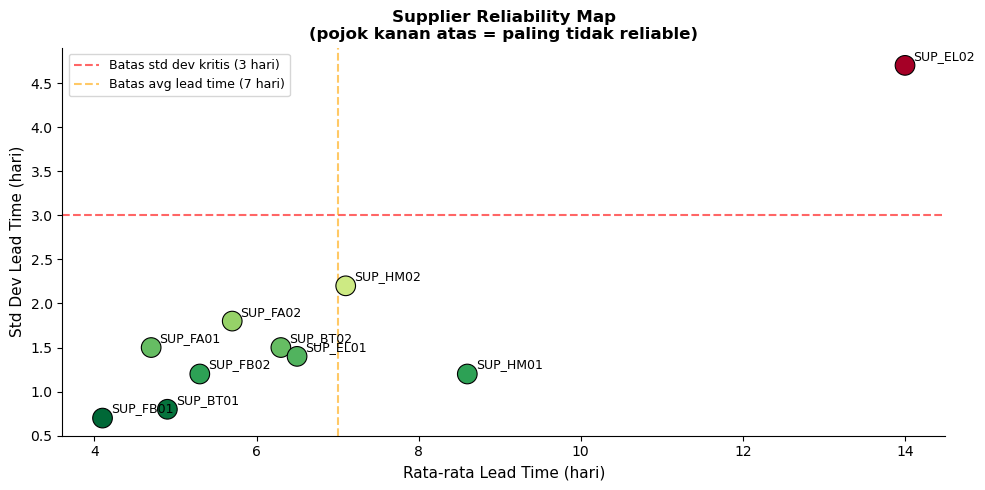

In [18]:
# Visualisasi: Supplier Reliability Map (scatter plot)
# Sumbu X = avg lead time, Sumbu Y = std dev lead time
# Pojok kanan atas = paling tidak reliable
sup = %sql SELECT SupplierID, ROUND(AVG(LeadTime),1) AS avg_lt, ROUND(STDDEV(LeadTime),1) AS std_lt     FROM inventory_clean GROUP BY SupplierID ORDER BY std_lt DESC
df_sup = sup.DataFrame()

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_sup['avg_lt'], df_sup['std_lt'],
           s=200, c=df_sup['std_lt'], cmap='RdYlGn_r',
           edgecolors='black', linewidths=0.8, zorder=3)

for _, row in df_sup.iterrows():
    ax.annotate(row['SupplierID'], (row['avg_lt'], row['std_lt']),
                textcoords='offset points', xytext=(6, 4), fontsize=9)

# Garis batas zona bermasalah
ax.axhline(3, color='red', linestyle='--', alpha=0.6, label='Batas std dev kritis (3 hari)')
ax.axvline(7, color='orange', linestyle='--', alpha=0.6, label='Batas avg lead time (7 hari)')
ax.set_xlabel('Rata-rata Lead Time (hari)', fontsize=11)
ax.set_ylabel('Std Dev Lead Time (hari)', fontsize=11)
ax.set_title('Supplier Reliability Map\n(pojok kanan atas = paling tidak reliable)', fontsize=12)
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

In [19]:
%%sql
-- Detail per SKU untuk supplier yang bermasalah
-- Tampilkan supplier dengan std dev > 3 hari ATAU avg lead time > 7 hari
SELECT
    SupplierID,
    SKU,
    ProductName,
    ROUND(AVG(LeadTime), 1)    AS avg_lead_time,
    ROUND(STDDEV(LeadTime), 1) AS stddev_lead_time,
    MIN(LeadTime)              AS min_lt,
    MAX(LeadTime)              AS max_lt
FROM inventory_clean
WHERE SupplierID IN (
    SELECT SupplierID FROM inventory_clean
    GROUP BY SupplierID
    HAVING STDDEV(LeadTime) > 3 OR AVG(LeadTime) > 7
)
GROUP BY SupplierID, SKU, ProductName
ORDER BY SupplierID, stddev_lead_time DESC;

SupplierID,SKU,ProductName,avg_lead_time,stddev_lead_time,min_lt,max_lt
SUP_EL02,SKU-003,Headphone Sony WH-1000,13.4,5.0,7.0,23.0
SUP_EL02,SKU-002,Smartphone Samsung A54,14.6,4.5,8.0,21.0
SUP_HM01,SKU-010,Rice Cooker Miyako 1.8L,8.4,1.4,6.0,10.0
SUP_HM01,SKU-009,Blender Philips HR2157,8.8,1.0,7.0,10.0
SUP_HM02,SKU-012,Kipas Angin Cosmos 16in,7.4,2.3,4.0,10.0
SUP_HM02,SKU-011,Vacuum Cleaner Deerma,6.8,2.1,4.0,10.0


---
## 6. Analisis Overstock & Modal Tertahan

**Definisi overstock:** `CurrentStock > 2 × ReorderPoint`  
Artinya stok lebih dari 2 kali lipat batas aman — ada kelebihan yang sia-sia mengikat modal.

**Mengapa 2× Reorder Point?**  
Stok antara 1× dan 2× reorder point masih masuk akal — ini adalah buffer normal untuk mengantisipasi variasi permintaan. Stok di atas 2× reorder point dianggap kelebihan sejati, karena jauh melampaui kebutuhan safety stock yang wajar.

**Modal Tertahan** = `(CurrentStock - ReorderPoint) × UnitPrice`  
Ini adalah nilai rupiah dari stok "kelebihan" di atas batas aman.  
Modal ini seharusnya bisa diputar untuk keperluan operasional lain.

In [20]:
%%sql
-- Overstock per kategori — rata-rata pada snapshot terbaru
SELECT
    Category,
    COUNT(DISTINCT SKU)  AS jumlah_sku,
    ROUND(AVG(CurrentStock), 1)  AS avg_stock,
    ROUND(AVG(ReorderPoint), 1)  AS avg_reorder_point,
    ROUND(AVG(CAST(CurrentStock AS FLOAT) / NULLIF(CAST(ReorderPoint AS FLOAT), 0)), 2) AS rasio_stock_vs_rop,
    SUM(CASE WHEN CurrentStock > 2 * ReorderPoint THEN 1 ELSE 0 END) AS jumlah_overstock
FROM inventory_clean
WHERE SnapshotDate = (SELECT MAX(SnapshotDate) FROM inventory_clean)
GROUP BY Category
ORDER BY rasio_stock_vs_rop DESC;

Category,jumlah_sku,avg_stock,avg_reorder_point,rasio_stock_vs_rop,jumlah_overstock
Beauty,4,202.8,54.0,3.81,5
Home & Living,4,31.0,22.5,1.13,1
Electronics,4,24.4,24.0,0.98,0
Food & Beverage,4,59.3,90.0,0.58,0
Fashion,4,0.0,42.5,0.0,0


In [21]:
%%sql
-- Modal tertahan per SKU pada snapshot terbaru
-- Hanya SKU yang stoknya melebihi reorder point
SELECT
    SKU,
    ProductName,
    Category,
    CurrentStock,
    ReorderPoint,
    UnitPrice,
    (CurrentStock - ReorderPoint) AS kelebihan_stok,
    ROUND((CurrentStock - ReorderPoint) * UnitPrice) AS modal_tertahan_rp
FROM inventory_clean
WHERE SnapshotDate = (SELECT MAX(SnapshotDate) FROM inventory_clean)
  AND CurrentStock > ReorderPoint
ORDER BY modal_tertahan_rp DESC;

SKU,ProductName,Category,CurrentStock,ReorderPoint,UnitPrice,kelebihan_stok,modal_tertahan_rp
SKU-013,Skincare Set Whitelab,Beauty,153.0,40,550000.0,113.0,62150000.0
SKU-013,Skincare Set Whitelab,Beauty,153.0,40,550000.0,113.0,62150000.0
SKU-015,Foundation Maybelline Fit,Beauty,223.0,60,165000.0,163.0,26895000.0
SKU-016,Parfum EDT Brasov 100ml,Beauty,217.0,50,125000.0,167.0,20875000.0
SKU-014,Lipstik Matte Wardah,Beauty,268.0,80,85000.0,188.0,15980000.0
SKU-009,Blender Philips HR2157,Home & Living,41.0,20,750000.0,21.0,15750000.0
SKU-012,Kipas Angin Cosmos 16in,Home & Living,57.0,30,350000.0,27.0,9450000.0
SKU-010,Rice Cooker Miyako 1.8L,Home & Living,44.0,25,450000.0,19.0,8550000.0
SKU-003,Headphone Sony WH-1000,Electronics,22.0,20,3200000.0,2.0,6400000.0
SKU-004,Smartwatch Xiaomi Band,Electronics,34.0,30,1200000.0,4.0,4800000.0


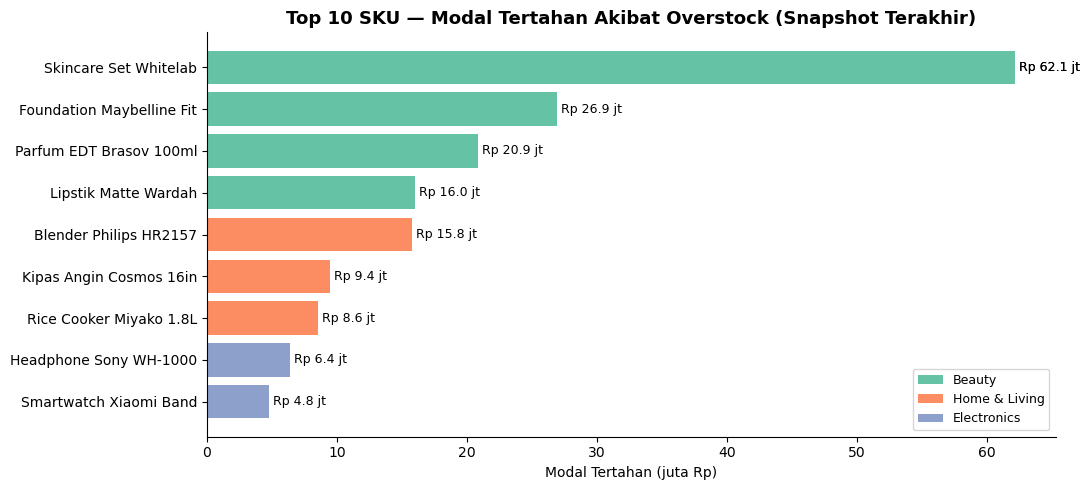

In [28]:
# Visualisasi: Modal tertahan per SKU (bar chart horizontal)
modal = %sql SELECT SKU, ProductName, Category,     ROUND((CurrentStock - ReorderPoint) * UnitPrice) AS modal_tertahan     FROM inventory_clean     WHERE SnapshotDate = (SELECT MAX(SnapshotDate) FROM inventory_clean)       AND CurrentStock > ReorderPoint     ORDER BY modal_tertahan DESC LIMIT 10
df_modal = modal.DataFrame()

fig, ax = plt.subplots(figsize=(11, 5))
palette = sns.color_palette('Set2', len(df_modal['Category'].unique()))
cat_colors = {c: palette[i] for i, c in enumerate(df_modal['Category'].unique())}
colors = [cat_colors[c] for c in df_modal['Category']]

bars = ax.barh(df_modal['ProductName'], df_modal['modal_tertahan'] / 1e6, color=colors)
for bar, val in zip(bars, df_modal['modal_tertahan']):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            f'Rp {val/1e6:.1f} jt', va='center', fontsize=9)

ax.set_xlabel('Modal Tertahan (juta Rp)')
ax.set_title('Top 10 SKU — Modal Tertahan Akibat Overstock (Snapshot Terakhir)')
ax.invert_yaxis()

legend_elements = [Patch(facecolor=cat_colors[c], label=c) for c in cat_colors]
ax.legend(handles=legend_elements, fontsize=9, loc='lower right')
plt.tight_layout()
plt.show()

---
## 7. Day of Stock vs Lead Time

**Day of Stock (DoS)** = `CurrentStock / DailySalesAvg`  
Artinya: dengan stok saat ini dan kecepatan penjualan, stok akan habis dalam berapa hari?

**Masalah kritis terjadi ketika:** `DoS <= Lead Time`  
Ini berarti stok habis **sebelum** pesanan dari supplier datang — **pasti stockout**.

Ini adalah **root cause paling langsung** dari stockout berulang — reorder point yang ada terlalu rendah dibanding kecepatan habisnya stok.

> **Catatan:** SKU dengan `DailySalesAvg = 0` dikecualikan dari perhitungan DoS karena pembagian dengan nol menghasilkan nilai tak terdefinisi.

In [23]:
%%sql
-- Day of Stock vs Lead Time per SKU — rata-rata seluruh 15 bulan
-- SKU dengan DailySalesAvg = 0 dikecualikan (DoS tidak terdefinisi)
SELECT
    SKU,
    ProductName,
    SupplierID,
    ROUND(AVG(CurrentStock / DailySalesAvg), 1) AS avg_day_of_stock,
    ROUND(AVG(LeadTime), 1)                     AS avg_lead_time,
    ROUND(
        AVG(CurrentStock / DailySalesAvg) - AVG(LeadTime),
        1
    ) AS buffer_hari,
    CASE
        WHEN AVG(CurrentStock / DailySalesAvg) <= AVG(LeadTime)
            THEN 'Kritis — Stok habis sebelum restock'
        WHEN AVG(CurrentStock / DailySalesAvg) <= AVG(LeadTime) * 1.5
            THEN 'Rentan — Buffer tipis'
        ELSE 'Aman'
    END AS status
FROM inventory_clean
WHERE DailySalesAvg > 0
GROUP BY SKU, ProductName, SupplierID
ORDER BY buffer_hari ASC;

SKU,ProductName,SupplierID,avg_day_of_stock,avg_lead_time,buffer_hari,status
SKU-002,Smartphone Samsung A54,SUP_EL02,3.9,14.6,-10.8,Kritis — Stok habis sebelum restock
SKU-003,Headphone Sony WH-1000,SUP_EL02,8.3,13.4,-5.1,Kritis — Stok habis sebelum restock
SKU-019,Madu Hutan Asli 500ml,SUP_FB02,2.6,5.3,-2.7,Kritis — Stok habis sebelum restock
SKU-007,Sepatu Sneakers Nike,SUP_FA02,2.9,5.5,-2.6,Kritis — Stok habis sebelum restock
SKU-020,Snack Granola Mix 500g,SUP_FB02,3.2,5.4,-2.2,Kritis — Stok habis sebelum restock
SKU-005,Kemeja Formal Pria,SUP_FA01,2.9,5.0,-2.1,Kritis — Stok habis sebelum restock
SKU-006,Dress Casual Wanita,SUP_FA01,2.4,4.4,-1.9,Kritis — Stok habis sebelum restock
SKU-018,Teh Organik Premium Box,SUP_FB01,2.4,4.2,-1.8,Kritis — Stok habis sebelum restock
SKU-008,Tas Ransel Eiger,SUP_FA02,4.4,5.9,-1.5,Kritis — Stok habis sebelum restock
SKU-017,Kopi Arabika 250g Pack,SUP_FB01,3.3,4.0,-0.7,Kritis — Stok habis sebelum restock


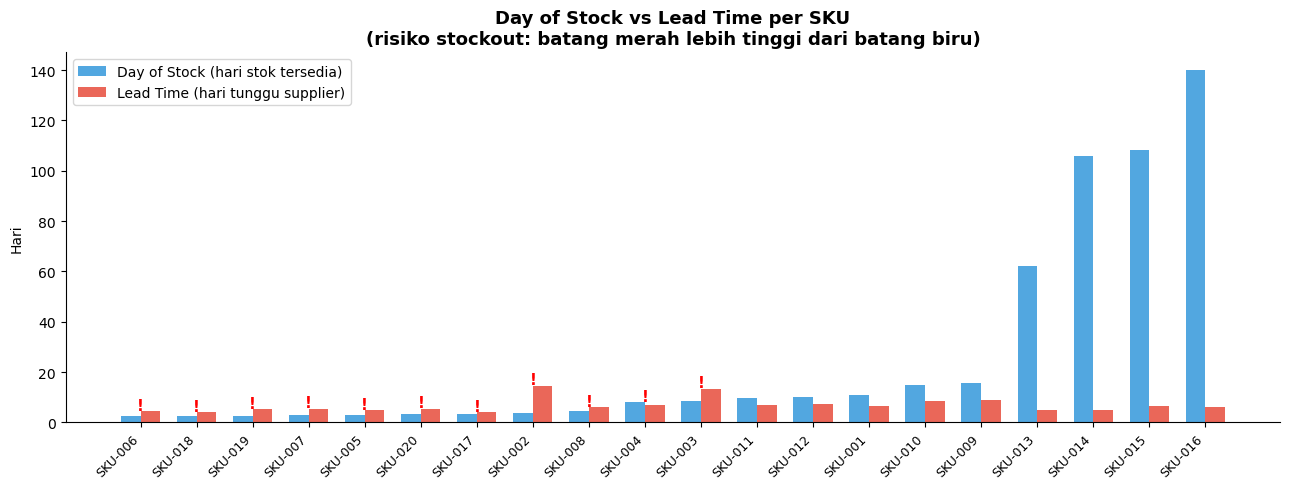

In [24]:
# Visualisasi: Day of Stock vs Lead Time — grouped bar chart per SKU
dos = %sql SELECT SKU,     ROUND(AVG(CurrentStock / DailySalesAvg), 1) AS avg_dos,     ROUND(AVG(LeadTime), 1) AS avg_lt     FROM inventory_clean WHERE DailySalesAvg > 0 GROUP BY SKU ORDER BY avg_dos ASC
df_dos = dos.DataFrame()

fig, ax = plt.subplots(figsize=(13, 5))
x = range(len(df_dos))
width = 0.35

ax.bar([i - width/2 for i in x], df_dos['avg_dos'], width,
       label='Day of Stock (hari stok tersedia)', color='#3498db', alpha=0.85)
ax.bar([i + width/2 for i in x], df_dos['avg_lt'], width,
       label='Lead Time (hari tunggu supplier)', color='#e74c3c', alpha=0.85)

ax.set_xticks(list(x))
ax.set_xticklabels(df_dos['SKU'], rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Hari')
ax.set_title('Day of Stock vs Lead Time per SKU\n(risiko stockout: batang merah lebih tinggi dari batang biru)')
ax.legend()

# Tandai SKU berisiko
for i, (dos_val, lt_val) in enumerate(zip(df_dos['avg_dos'], df_dos['avg_lt'])):
    if float(dos_val) <= float(lt_val) * 1.2:
        ax.annotate('!', (i, max(float(dos_val), float(lt_val)) + 0.5),
                    ha='center', fontsize=11, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

---
## 8. Ringkasan & Rekomendasi untuk Pak Yusuf

### Temuan Utama

| # | Masalah | Detail | Dampak |
|---|---------|--------|--------|
| 1 | **Stockout Kritis** | Beberapa SKU mengalami stockout di > 50% bulan yang dicatat | Kehilangan penjualan langsung |
| 2 | **Supplier Tidak Reliable** | Supplier dengan std dev lead time > 3 hari membuat planning stok tidak bisa diandalkan | Stockout tak terduga |
| 3 | **Overstock** | Beberapa kategori menahan modal besar di stok yang berlebihan | Modal tidak produktif |
| 4 | **DoS <= Lead Time** | Banyak SKU kehabisan stok sebelum restock tiba | Root cause utama stockout |

### Rekomendasi

1. **Naikkan Reorder Point** untuk SKU dengan DoS <= Lead Time  
   Formula baru: `Reorder Point = (DailySalesAvg × LeadTime) + Safety Stock`  
   Safety Stock = `DailySalesAvg × StdDev(LeadTime) × 1.65` (service level 95%)

2. **Evaluasi/Ganti Supplier Bermasalah**  
   Minta SLA tertulis dari supplier dengan std dev > 3 hari, atau cari alternatif supplier

3. **Kurangi Overstock** di kategori dengan rasio stock > 2× reorder point  
   Pertimbangkan flash sale atau transfer stok antar gudang

4. **Pasang Alert Otomatis**  
   Kirim notifikasi ketika `CurrentStock < ReorderPoint` di sistem WMS

---
*Analisis dilakukan dengan JupySQL + DuckDB | Data: 20 SKU × 15 bulan (Jan 2025–Mar 2026)*

In [25]:
%%sql
-- ── Ringkasan Eksekutif ────────────────────────────────────────────────────
SELECT 'Total Records'   AS metrik, CAST(COUNT(*) AS VARCHAR) AS nilai
FROM inventory_clean
UNION ALL
SELECT 'Total SKU', CAST(COUNT(DISTINCT SKU) AS VARCHAR)
FROM inventory_clean
UNION ALL
SELECT 'Total Bulan', CAST(COUNT(DISTINCT SnapshotDate) AS VARCHAR)
FROM inventory_clean
UNION ALL
SELECT 'SKU Pernah Stockout', CAST(COUNT(DISTINCT SKU) AS VARCHAR)
FROM inventory_clean WHERE CurrentStock < ReorderPoint
UNION ALL
SELECT 'Total Kejadian Stockout',
    CAST(SUM(CASE WHEN CurrentStock < ReorderPoint THEN 1 ELSE 0 END) AS VARCHAR)
FROM inventory_clean
UNION ALL
SELECT 'Stockout Rate Keseluruhan',
    CONCAT(
        CAST(ROUND(100.0 * SUM(CASE WHEN CurrentStock < ReorderPoint THEN 1 ELSE 0 END) / COUNT(*), 1) AS VARCHAR),
        '%'
    )
FROM inventory_clean;

metrik,nilai
Total Records,312
Total SKU,20
Total Bulan,15
SKU Pernah Stockout,17
Total Kejadian Stockout,167
Stockout Rate Keseluruhan,53.5%
